In [10]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 

In [11]:
# Changing column names
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']
print(X)

     Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                    0.98         514.5      294.0     110.25             7.0   
1                    0.98         514.5      294.0     110.25             7.0   
2                    0.98         514.5      294.0     110.25             7.0   
3                    0.98         514.5      294.0     110.25             7.0   
4                    0.90         563.5      318.5     122.50             7.0   
..                    ...           ...        ...        ...             ...   
763                  0.64         784.0      343.0     220.50             3.5   
764                  0.62         808.5      367.5     220.50             3.5   
765                  0.62         808.5      367.5     220.50             3.5   
766                  0.62         808.5      367.5     220.50             3.5   
767                  0.62         808.5      367.5     220.50             3.5   

     Orientation  Glazing A

In [12]:
orientation_encoding = pd.get_dummies(X['Orientation'], prefix='Orientation', prefix_sep='=')
glazing_area_encoding = pd.get_dummies(X['Glazing Area Distribution'], prefix='Glazing_Area_Distribution', prefix_sep='=')
X = pd.concat([X.drop('Orientation', axis=1), orientation_encoding], axis=1)
X = pd.concat([X.drop('Glazing Area Distribution', axis=1), glazing_area_encoding], axis=1)
y1 = y['Heating Load'].values
y2 = y['Cooling Load'].values

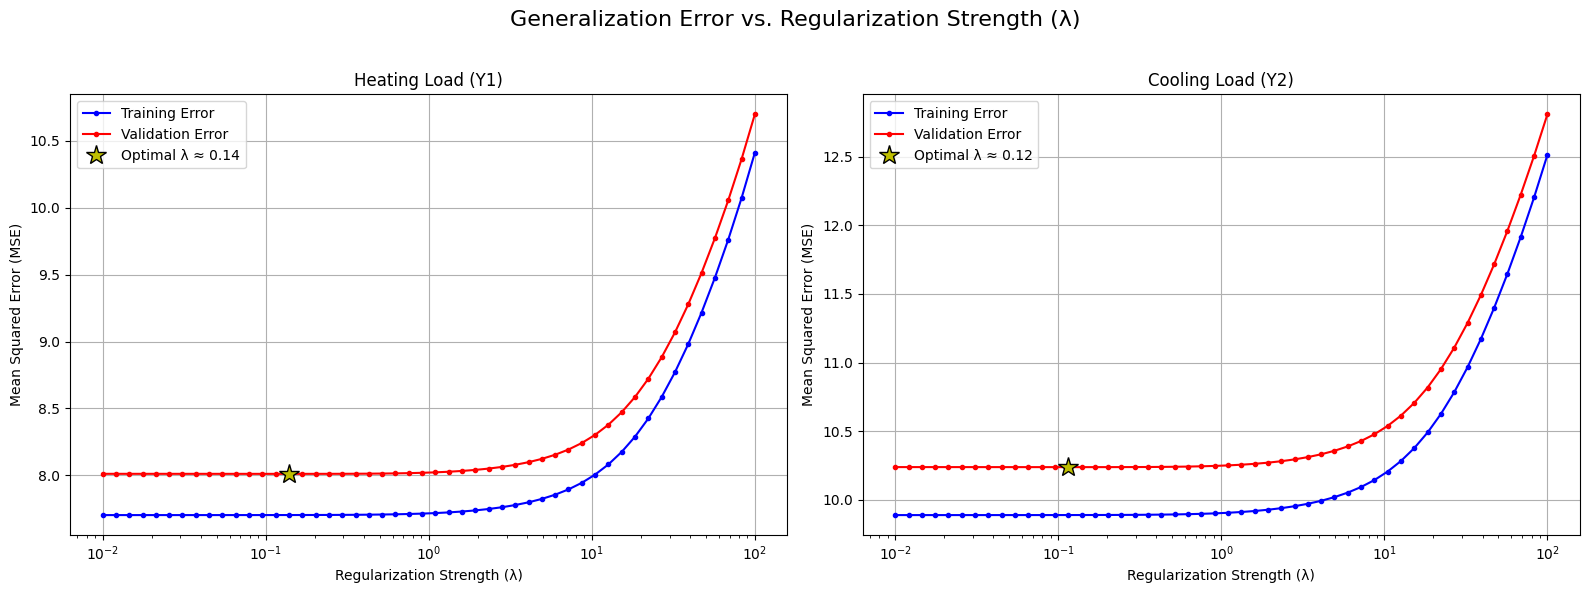

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

lambdas = np.logspace(-2, 2, 50)
K = 10
cv = KFold(n_splits=K, shuffle=True, random_state=42)
numerical_features = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']

def evaluate_regularization(y):

    avg_train_errors = []
    avg_test_errors = []

    for lambda_val in lambdas:
        train_errors_fold = []
        test_errors_fold = []

        for train_index, test_index in cv.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            

            mu = X_train[numerical_features].mean(axis=0)
            sigma = X_train[numerical_features].std(axis=0)
            

            sigma[sigma == 0] = 1 
            

            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            

            X_train_scaled[numerical_features] = (X_train[numerical_features] - mu) / sigma
            X_test_scaled[numerical_features] = (X_test[numerical_features] - mu) / sigma

            model = Ridge(alpha=lambda_val)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)
            
            train_errors_fold.append(mean_squared_error(y_train, y_train_pred))
            test_errors_fold.append(mean_squared_error(y_test, y_test_pred))

        avg_train_errors.append(np.mean(train_errors_fold))
        avg_test_errors.append(np.mean(test_errors_fold))
        
    return avg_train_errors, avg_test_errors


hl_train_errors, hl_test_errors = evaluate_regularization(y1)

cl_train_errors, cl_test_errors = evaluate_regularization(y2)

opt_lambda_hl_idx = np.argmin(hl_test_errors)
opt_lambda_hl = lambdas[opt_lambda_hl_idx]
min_error_hl = hl_test_errors[opt_lambda_hl_idx]

opt_lambda_cl_idx = np.argmin(cl_test_errors)
opt_lambda_cl = lambdas[opt_lambda_cl_idx]
min_error_cl = cl_test_errors[opt_lambda_cl_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Generalization Error vs. Regularization Strength (λ)', fontsize=16)

ax1.semilogx(lambdas, hl_train_errors, 'b.-', label='Training Error')
ax1.semilogx(lambdas, hl_test_errors, 'r.-', label='Validation Error')
ax1.semilogx(opt_lambda_hl, min_error_hl, 'y*', markersize=15, markeredgecolor='k', label=f'Optimal λ ≈ {opt_lambda_hl:.2f}')
ax1.set_title('Heating Load (Y1)')
ax1.set_xlabel('Regularization Strength (λ)')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.legend()
ax1.grid(True)

ax2.semilogx(lambdas, cl_train_errors, 'b.-', label='Training Error')
ax2.semilogx(lambdas, cl_test_errors, 'r.-', label='Validation Error')
ax2.semilogx(opt_lambda_cl, min_error_cl, 'y*', markersize=15, markeredgecolor='k', label=f'Optimal λ ≈ {opt_lambda_cl:.2f}')
ax2.set_title('Cooling Load (Y2)')
ax2.set_xlabel('Regularization Strength (λ)')
ax2.set_ylabel('Mean Squared Error (MSE)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


